# Week 2 - Sampling & Reliability

Up until this week, we have assumed that the corpus you have used for analysis assignments represented a *meaningful* assemblage of texts from which reasonable inferences could be drawn about the social game, social world and social actors that produced it. 

This week, we ask you to build a corpus for preliminary analysis and articulate what your sample represents in context of your final project. We begin by exploring how we can get *human* readings of content at scale. We want to gather and utilize human responses for several reasons. First, we may want to use crowdsourced human scores as the primary method of coding, extracting or organizing content (as it was in two of the assigned readings). Second, we may want to validate or tune a computational algorithm we may have developed in terms of how it is associated with human meanings or experience. Finally, we may want to use human coding on a sample of data as the basis for training a model or algorithm to then extrapolate *human-like* annotations to the entire population. Here intelligent sampling is critical to maximize effective maching training. 

For this notebook we will be using the following packages

In [ ]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Pitch the Domain of your Project*</span>

<span style="color:red">In the two cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words) and **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words)? [**Note**: your individual or collective project can change over the course of the quarter if new data and/or analysis opportunities arise or if old ones fade away.]

## ***What?*** 

I'm planning to analyze online profiles (likely from Twitter) to predict their behavioral traits.
I will be analyzing behaviour by using a Jungian personality archetype framework - in which
personality can be classified into 16 types. The profile data I plan to collect will consist of
a persons "likes", own tweets and retweets, and the list of followers. Crucially, the profiles
that I plan to scrape will be self-tagged by personality (ie they declare their type), which is one
of 16 possible. This provides us the labels needed for a classifier.

## ***Why?***
Jungian personality archetypes are enormously popular in popular culture as many see them as accurate
in their analysis. The trait framework is similar to that of the Big-5 and can be used for
predictive analysis of behavior (t is also highly popular in organizational psychology/industry).
As this conception of personality type is regarded as 'innate' by theorists, this online-profile based
methodology to predict type would serve as a useful theoretical construct to understand social behaviour and
causality in online social networks.

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

The sample I plan to collect is profile data from Twitter which includes a person's "likes",
tweets and followers. Personality traits would theoretically heavily influence a person's
interests, information consumption patterns, and choice of social sphere in which they participate in.
These factors would at least be partially captures by the kind of tweets people consume (and hence like),
the kind of people they follow (the social game they participate in), and the kind of tweets they write.
These should help us classify people's personalities. The primary limitations arise from the data
being biased by the choice of social platform (as the choice of platform is linked with the social
game being played). The alternative would be to include profiles from other websites as well (Reddit).
Collecting more samples from a variety of different websites would be the best way to scale up the
sample for further analysis.

# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

In [ ]:
%%html
<img source="loopdesign.png">

[Click here for loop design](loopdesign.png)

In [ ]:
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [ ]:
anno.annotations

In [ ]:
anno.labels

In [ ]:
anno.missing_values

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [ ]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

In [ ]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [ ]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [ ]:
fleiss_kappa(anno.annotations[::])

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [ ]:
krippendorffs_alpha(anno.annotations[::])

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [ ]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

In [ ]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

In [ ]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [ ]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [ ]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

Or averaged over the total:

In [ ]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

In [ ]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [ ]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

## <span style="color:red">*Your turn*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides in the Assignment link on Canvas, or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

The data for this section was obtained from MTurk. The HIT was to rate Twitter profiles on a five point scale
where 1 corresponded to "highly artificial/possibly a bot" to 5 - natural, highly life-like, realistic.

A total of 8 profiles was rated by 5 coders, who could classify them into 5 classes as described above.

In [170]:
data = pandas.read_csv("Rate Twitter profile natural-ness (Responses) - Form Responses 1.csv")
data.drop('Timestamp', axis = 1, inplace= True)
data.columns = [i for i in range(0,8)]

In [171]:
print(data)
x = np.array(data).T
mtAnno = AnnotationsContainer.from_array(x)

   0  1  2  3  4  5  6  7
0  4  1  5  3  1  3  5  3
1  3  2  2  3  4  2  2  1
2  4  2  3  4  5  3  2  3
3  4  4  3  4  2  4  3  2
4  4  3  3  5  5  4  3  4


In [172]:
mtAnno.labels

[1, 2, 3, 4, 5]

# Statistics

In [173]:
pyanno.measures.agreement.labels_frequency(mtAnno.annotations, 5)

array([0.075, 0.2  , 0.325, 0.275, 0.125])

Confusion matrix between #2 and #3

[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [1. 2. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 1. 0.]]


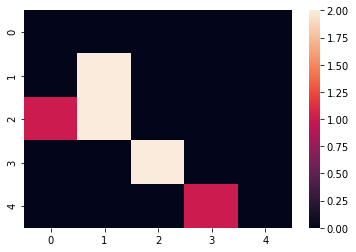

In [174]:
c = pyanno.measures.agreement.confusion_matrix(mtAnno.annotations[:,2], mtAnno.annotations[:,1],5)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's Pi pairwise plot:

In [175]:
m = pairwise_matrix(scotts_pi, mtAnno.annotations)
print(m)

[[ 1.         -0.13131313  0.17525773 -0.15463918 -0.2173913 ]
 [-0.13131313  1.         -0.04347826 -0.43820225 -0.31958763]
 [ 0.17525773 -0.04347826  1.          0.1011236   0.12087912]
 [-0.15463918 -0.43820225  0.1011236   1.          0.26436782]
 [-0.2173913  -0.31958763  0.12087912  0.26436782  1.        ]]


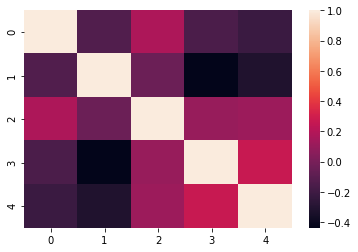

In [176]:
ax = seaborn.heatmap(m)
plt.show()

Fleiss Kappa:

In [177]:
fleiss_kappa(mtAnno.annotations[::])

-0.02310231023102316

Krippendorff's Alpha:
This is the most relevant one for our sample, as we use a Likert scale (closer numbers are closer categories)

In [178]:
krippendorffs_alpha(mtAnno.annotations[:,:])

0.001004520341536752

Cohen's Kappa pairwise plot:

In [179]:
m = pairwise_matrix(cohens_kappa, mtAnno.annotations)
print(m)

[[ 1.         -0.01818182  0.21568627 -0.03703704 -0.16666667]
 [-0.01818182  1.          0.         -0.33333333 -0.16363636]
 [ 0.21568627  0.          1.          0.13043478  0.14893617]
 [-0.03703704 -0.33333333  0.13043478  1.          0.30434783]
 [-0.16666667 -0.16363636  0.14893617  0.30434783  1.        ]]


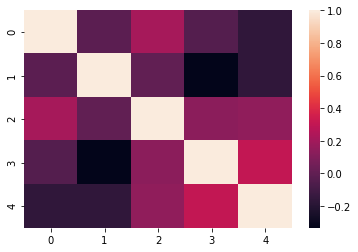

In [180]:
ax = seaborn.heatmap(m)
plt.show()

Cohen's weighted kappa average:

In [181]:
m = pairwise_matrix(cohens_weighted_kappa, mtAnno.annotations)
print(m)

[[ 1.         -0.14285714  0.02222222  0.         -0.24444444]
 [-0.14285714  1.          0.28205128 -0.15789474  0.05882353]
 [ 0.02222222  0.28205128  1.          0.          0.42857143]
 [ 0.         -0.15789474  0.          1.          0.125     ]
 [-0.24444444  0.05882353  0.42857143  0.125       1.        ]]


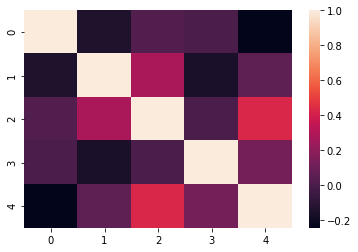

In [182]:
ax = seaborn.heatmap(m)
plt.show()

Average:

In [183]:
pairwise_metric_average(cohens_weighted_kappa,mtAnno.annotations)

0.037147213811300504

Pearson and spearman correlation plots:

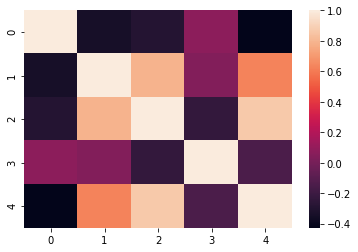

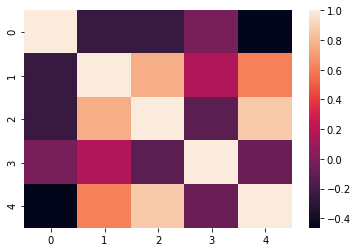

In [184]:
n = pairwise_matrix(pearsons_rho, mtAnno.annotations)
m = pairwise_matrix(spearmans_rho, mtAnno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Averages:

In [185]:
print(pairwise_metric_average(pearsons_rho,mtAnno.annotations), pairwise_metric_average(spearmans_rho,mtAnno.annotations))

0.09781499214804448 0.12641434797744167


# Discussion

The statistics above indicate that overall, the coders do not seem to agree with one another very much. The average correlation and similarity coefficients are not very high,
even when the distances are weighted to account for closer and larger dissimilarities.

Fleiss kappa: -0.02310231023102316 - indicates worse than chance agreement (!), when classes are considered equally dissimilar.

Krippendoff's alpha: 0.001004520341536752 - not much improvement over Fleiss Kappa. This is not a good sign for our data as this metric weights distances (which is necessary for our task). The low number indicates that coders are not in much agreement with one another.

Cohen's weighted kappa: 0.037147213811300504.

The low values of values of these coefficient could be because of 1-2 highly bad-quality analysts and should not mean that there is no useful information in the data. We explore this possibility in the next section.

The pairwise plots show that while some of the coders agree with each other consistently over others (2 & 3, 4 & 5), the average is brought down
due to highly dissimilar scoring by #1 and the other coders, and also a general lack of agreement between others.

The spearman correlation coeffient (calulated below) (which is more appropriate than the pearson correlation coefficient in this scenario),
indicates that there is certainly some sense of ordinality amongst the coders. This is especially important for this task.

# Implications

This lack of agreement has two primary sources: Poor efforts by the MTurk workers and general subjectivity of the
task which leads to different opinions.

1) Much of the variation in the codings could be attributed to different (but valid) interpretations of the instructions
given for the task (the meaning of 'realistic', 'fake' has multiple meanings. Some of the variation could, of course, have been random error.

Note that despite the lack of agreement, a manual inspection revealed that most (4/5) made accurate, or otherwise justifiable choices that contained useful information.
Overall, the implications for this domain are that:

1) A large amount of 'natural' variation resulting due to participant subjectivity is expected, more so than that expected from, say, visual object classification tasks.

2) Focussing on identifying and excluding coders who consistently make 'obviously' wrong responses is necessary as low quality analysts are common on MTurk.

3) Despite these drawbacks, it appears that the coders were (reasonably) consistent for some estimations and provided some useful classifications.
This should demonstrate that if the task instructions were more refined, it might be quite feasible to use human workers for mass-annotations for this task.

# Models

However, what if some coders are better than others. The prior measures all rely on the assumption that all coders are equally good. What if some are worse than others? Now we use Rzhetsky et al (2009) and Dawid & Skene's models to make inference about true label classes by downweighting bad or deviant coders. Pyanno provides three relevant models: ModelA, ModelB, and ModelBt. Model A can only be currently run on a balanced 8-coder design, but assesses accuracy purely based on agreement. Model B with $\theta$s models the relationship between each coder and code. Model B is the Dawid & Skene model from the reading. The following image schematically suggests the relationship between the models. <img src="../data/models.png">

The models should provide similar results. To estimate the parameters for any models, we first need to create a new model. 

In [ ]:
# create a new instance of model A, with 4 label classes
model = ModelB.create_initial_state(4, 8)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

In [ ]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

Pyanno allows one to use either MLE (maximum likelihood estimation) or MAP (maximum a posteriori estimation) to estimate model parameters. Note that the parameters here correspond to our estimation of the accuracy of each annotator.

In [ ]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

In [ ]:
model = ModelB.create_initial_state(4, 8)
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

Once we have model parameters estimated, we can now make inferences about the true label classes. We can calculate the posterior distribution over the true label classes.

In [ ]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

Let's turn the posterior of the first 100 samples into a heatmap.

In [ ]:
votes = []
for r in anno.annotations:
    v = [0] * len(anno.labels)
    votes.append(v)
    for a in r:
        if a > -1:
            v[a] += 1
votes_array = np.array(votes)

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)
num_questions = 20

seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
seaborn.heatmap(posterior[:num_questions], annot=True, ax =ax1)
ax1.set_title("Model")
ax2.set_title("Votes")
plt.show()

This differs markedly from taking annotator scores at face value (Add comparison of average values)

In [ ]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [ ]:
print(samples[0].mean(axis=0))
print(samples[0].std(axis=0))

Let's try everything again with ModelBt

In [ ]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 8)
print(model.theta)
print(model.log_likelihood(anno.annotations))

In [ ]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

In [ ]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

Let's visualize the posterior of the first 10 samples according to ModelBt.

In [ ]:
ax = seaborn.heatmap(posterior[:10,])
plt.show()

The property of these scores is that they enable us to identify the most likely code assuming coders of unequal quality, which also allows us to break ties when we know coder identity. For some analyses, we may simply use the posterior themselves rather than the most probably code outcome.

# Generating Annotations

Pyanno also allows one to generate artificial data from a model.

In [ ]:
model = ModelBt.create_initial_state(4, 3, theta=[0.99,0.75,0.25])
#randome generate annotations with 4 label classes and 3 annotators. The accuracy of the three annotators are 0.99, 0.75, and 0.25 respectively.
model.generate_annotations(20)

## Visualizing coder accuracy

Pyanno provides a [graphical user interface](http://docs.enthought.com/uchicago-pyanno/user_guide.html) for making plots. However, it is not compatible with ipython notebooks. Nevertheless, nothing prevents us from making plots using matplotlib. Let's make a plot of the accuracy of each annotator inferred from ModelA.

In [ ]:
model = ModelBt.create_initial_state(4, 8)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)#.mean(axis = 1).mean(axis = 1)
y_ci = samples.std(axis=0)#.mean(axis = 1).mean(axis = 1)

In [ ]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()

# Example with articles that use the General Social Survey

I performed a recent study in which the variables from thousands of articles were associated with those used in the General Social Survey, a widely used population sample, in order to interrogate how social science analyses are performed. Each article was reread and coded by a balanced set of three student coders using a 6 choose 3 design, such that all possible 3-coder-subsets (20) coded an equal number of articles. Coding was performed through a website that allowed students access to the digital article. To evaluate the validity of the student codes, we also recruited a sample of authors associated with 97 of our published articles to fill out the same online survey. 

Because not all coders coded items with equal accuracy, and because “don’t know” was an optional answer, leading to potential ties, we used a generative, probabilistic model to estimate the maximum a posteriori probability (MAP) prediction that an item’s code is true, which integrates over the estimated accuracy of coders, assuming only that the entire population of coders is slightly more often right than wrong. The model (“Model B”) is based on a simple underlying generation process that directly accounts for the probability that coded values are correct (Rzhetsky et al. 2009). For each coded value j, a set of parameters, denoted γj, represents the probability that each coded value is correct. For the ith coder (i = 1, 2, …, 6), we introduce a matrix of probabilities, denoted λ(i)x|y, that defines the probability that she assigns code x (e.g., Dependent variable) to a GSS variable with correct annotation y. For a perfect coder, the matrix λ(i)x|y would equal the identity matrix and her vote would count most toward the total. For a coder that always codes incorrectly—a “troll”—her matrix λ(i)x|y will have all its value off the diagonal and will only minimally influence the posterior. We co-authored the open source pyanno software that implements this model.

Getting the data for each content analysis survey regarding how GSS variables were used in a large population of social science articles.

In [ ]:
#anno_vdep = AnnotationsContainer.from_file(missing_values=[-1], filename="GSSvariable_testSdependent.csv")
dev = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testSdependent.csv", dtype=int, delimiter=",")
anno_dv = AnnotationsContainer.from_array(dev)

ind = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testSindependent.csv", dtype=int, delimiter=",")
anno_iv = AnnotationsContainer.from_array(ind)

cent = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testScentral.csv", dtype=int, delimiter=",")
anno_cv = AnnotationsContainer.from_array(cent)

cont = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testScontrol.csv", dtype=int, delimiter=",")
anno_ctv = AnnotationsContainer.from_array(cont)

test = np.loadtxt(fname="../data/dataforgssstudy/testH.csv", dtype=int, delimiter=",")
anno_test = AnnotationsContainer.from_array(test)

Let's examine the data structure.

In [ ]:
dev.shape

In [ ]:
anno_dv.labels

In [ ]:
anno_dv.missing_values

In [ ]:
anno_dv.annotations.shape

First, let's use Cohen's $\kappa$ to measure agreement between coders...

In [ ]:
m = pairwise_matrix(cohens_kappa, anno_dv.annotations)
print(m)

Let's visualize that...

In [ ]:
ax = seaborn.heatmap(m)
plt.show()

In [ ]:
pairwise_metric_average(cohens_kappa, anno_dv.annotations)

Let's compute the statistics on each of the datasets and with Pearson's $\rho$. 

In [ ]:
datasets = [anno_dv.annotations, anno_iv.annotations, anno_cv.annotations, anno_ctv.annotations]
ck = [pairwise_matrix(cohens_kappa, anno) for anno in datasets]
pr = [pairwise_matrix(pearsons_rho, anno) for anno in datasets]
titles = ['DV', 'IV', 'Central Variable', "Control Variable"]

In [ ]:
fig, axs = plt.subplots(2,4)
fig.set_size_inches(18, 7)
for k, ax, title in zip(ck,axs[0], titles):
    seaborn.heatmap(k, ax = ax)
    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())
for r, ax in zip(pr,axs[1]):
    seaborn.heatmap(r, ax = ax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

Now we will compare the student coders.

In [ ]:
nondiag = (np.eye(6)-np.ones(6))*-1.0

In [ ]:
xdevck = pairwise_matrix(cohens_kappa, anno_dv.annotations)
xdevpr = pairwise_matrix(pearsons_rho, anno_dv.annotations)

xindck = pairwise_matrix(cohens_kappa, anno_iv.annotations)
xindpr = pairwise_matrix(pearsons_rho, anno_iv.annotations)

xcenck = pairwise_matrix(cohens_kappa, anno_cv.annotations)
xcenpr = pairwise_matrix(pearsons_rho, anno_cv.annotations)

xconck = pairwise_matrix(cohens_kappa, anno_ctv.annotations)
xconpr = pairwise_matrix(pearsons_rho, anno_ctv.annotations)

print(np.average(xdevck, weights=nondiag))
print(np.average(xdevpr, weights=nondiag))
print(np.average(xindck, weights=nondiag))
print(np.average(xindpr, weights=nondiag))
print(np.average(xcenck, weights=nondiag))
print(np.average(xcenpr, weights=nondiag))
print(np.average(xconck, weights=nondiag))
print(np.average(xconpr, weights=nondiag))

Now we are going to bring in "gold standard" data. In this case, this is where we asked authors of the articles to code their own article's variables and compare with our student coders.

In [ ]:
mergedata = np.loadtxt(fname="../data/dataforgssstudy/gss_mergedataC.txt", dtype=int, delimiter="\t")

In [ ]:
anno_merge_dep = AnnotationsContainer.from_array(mergedata[:,0:2])
anno_merge_ind = AnnotationsContainer.from_array(mergedata[:,2:4])
anno_merge_cen = AnnotationsContainer.from_array(mergedata[:,4:6])
anno_merge_con = AnnotationsContainer.from_array(mergedata[:,6:8])
anno_merge_dkn = AnnotationsContainer.from_array(mergedata[:,8:10])

In [ ]:
print("""Dependent variable -- kappa & rho""")
print(cohens_kappa(anno_merge_dep.annotations[:,0], anno_merge_dep.annotations[:,1]))
print(pearsons_rho(anno_merge_dep.annotations[:,0], anno_merge_dep.annotations[:,1]))

print("\nIndependent variable")
print(cohens_kappa(anno_merge_ind.annotations[:,0], anno_merge_ind.annotations[:,1]))
print(pearsons_rho(anno_merge_ind.annotations[:,0], anno_merge_ind.annotations[:,1]))

print("\nCentral variable")
print(cohens_kappa(anno_merge_cen.annotations[:,0], anno_merge_cen.annotations[:,1]))
print(pearsons_rho(anno_merge_cen.annotations[:,0], anno_merge_cen.annotations[:,1]))

print("\nControl variable")
print(cohens_kappa(anno_merge_con.annotations[:,0], anno_merge_con.annotations[:,1]))
print(pearsons_rho(anno_merge_con.annotations[:,0], anno_merge_con.annotations[:,1]))

Whoah! Student coders and authors viewed articles that were "central" or critical to the published argument as fundamentally different (exhibiting negative agreement and correlation). Why? Likely because that researchers recalled what they had _intended_ as their central variables before analysis, but those that _worked out_ became central in the text.

Now for the assessment of the relative values of authors, then student coders.

In [ ]:
print("Dependent")
print(np.average(anno_merge_dep.annotations[:,0]))
print(np.average(anno_merge_dep.annotations[:,1]))

print("\nIndependent")
print(np.average(anno_merge_ind.annotations[:,0]))
print(np.average(anno_merge_ind.annotations[:,1]))

print("\nCentral")
print(np.average(anno_merge_cen.annotations[:,0]))
print(np.average(anno_merge_cen.annotations[:,1]))

print("\nControl")
print(np.average(anno_merge_con.annotations[:,0]))
print(np.average(anno_merge_con.annotations[:,1]))

## Now we are going to use models to predict the correct annotations

Recall that Model A is built for 8 coders, but we have 6. We're going to *hack* it by adding two blank columns.

In [ ]:
dev.shape

In [ ]:
negs2 = np.ones((21461, 2), dtype=np.int)*(-1)
devA = np.concatenate((dev, negs2), axis=1)
devA

In [ ]:
anno_dvA = AnnotationsContainer.from_array(devA)
model_devA = ModelA.create_initial_state(2)
model_devA.theta

In [ ]:
model_dvB = ModelB.create_initial_state(2, 6)
print(model_dvB.pi)
print(model_dvB.log_likelihood(anno_dv.annotations))

In [ ]:
model_dvB.map(anno_dv.annotations)
print(model_dvB.pi)
print(model_dvB.log_likelihood(anno_dv.annotations))

In [ ]:
# compute the posterior distribution over true annotations
posterior_dvB = model_dvB.infer_labels(anno_dv.annotations)
# each row show the probability of each label class for the
# corresponding item
print(posterior)

In [ ]:
samples_dvB = model_dvB.sample_posterior_over_accuracy(anno_dv.annotations, 200, burn_in_samples=100, thin_samples=3)

In [ ]:
# we can then compute a credible interval for the parameters:
ci_dv_mean = samples_dvB[0].mean(axis=0)
print("Mean")
print(ci_dv_mean)

ci_dv_stdev = samples_dvB[0].std(axis=0)
print("\nSTD")
print(ci_dv_stdev)


We will use Model B estimates for other variable assessments.

In [ ]:
#test
model_testB = ModelB.create_initial_state(2, 6)
print(model_testB.log_likelihood(anno_test.annotations))
model_testB.map(anno_test.annotations)
print(model_testB.pi)
print(model_testB.log_likelihood(anno_test.annotations))
print(anno_test.annotations.shape)
posterior_testB = model_testB.infer_labels(anno_test.annotations)
print(posterior_testB.shape)
samples_testB = model_testB.sample_posterior_over_accuracy(anno_test.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_test_mean = samples_testB[0].mean(axis=0)
print(ci_test_mean)

In [ ]:
#indepedent variables
model_ivB = ModelB.create_initial_state(2, 6)
print(model_ivB.log_likelihood(anno_iv.annotations))
model_ivB.map(anno_iv.annotations)
print(model_ivB.pi)
print(model_ivB.log_likelihood(anno_iv.annotations))
print(anno_iv.annotations.shape)
posterior_ivB = model_ivB.infer_labels(anno_iv.annotations)
print(posterior_ivB.shape)
samples_ivB = model_ivB.sample_posterior_over_accuracy(anno_iv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_iv_mean = samples_ivB[0].mean(axis=0)
print(ci_iv_mean)

#central variables
model_cvB = ModelB.create_initial_state(2, 6)
print(model_cvB.log_likelihood(anno_cv.annotations))
model_cvB.map(anno_cv.annotations)
print(model_cvB.pi)
print(model_cvB.log_likelihood(anno_cv.annotations))
print(anno_cv.annotations.shape)
posterior_cvB = model_cvB.infer_labels(anno_cv.annotations)
print(posterior_cvB.shape)
samples_cvB = model_cvB.sample_posterior_over_accuracy(anno_cv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_cv_mean = samples_cvB[0].mean(axis=0)
print(ci_cv_mean)

#control variables
model_ctvB = ModelB.create_initial_state(2, 6)
print(model_ctvB.log_likelihood(anno_ctv.annotations))
model_ctvB.map(anno_ctv.annotations)
print(model_ctvB.pi)
print(model_ctvB.log_likelihood(anno_ctv.annotations))
print(anno_ctv.annotations.shape)
posterior_ctvB = model_ctvB.infer_labels(anno_ctv.annotations)
print(posterior_ctvB.shape)
samples_ctvB = model_ctvB.sample_posterior_over_accuracy(anno_iv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_ctv_mean = samples_ctvB[0].mean(axis=0)
print(ci_ctv_mean)

Now we will package up the predicted data into a format we can use for other, subsequent analysis:

In [ ]:
print(posterior_dvB.shape)
print(posterior_ivB.shape)
print(posterior_cvB.shape)
print(posterior_ctvB.shape)

In [ ]:
predicted_annotations = np.concatenate((posterior_dvB, posterior_ivB, posterior_cvB, posterior_ctvB), axis=1) # posterior_dvBt, posterior_ivBt, posterior_cvBt, posterior_ctvBt), axis=1)

In [ ]:
predicted_annotations.shape

These annotations allowed us to uncover the degree to which social scientists alter their models to achieve a better fit...undocumented data mining. The answer was that social scientists did mine their data, but that it likely improved their analysis because change in the social world was the result of greater distortion than undocumented data mining.

## Another example analysis looks at a different data set of Hotel Reviews by a variety of patrons.

In [ ]:
df_hotels = pandas.read_csv('../data/hot_Reviews.csv', index_col=0)
df_hotels[:5]

Here a rank of 0 is a missing value and to simplify things more we will convert from a 1-10 scale to a 1-5 scale, with 0 as missing

In [ ]:
df_hotels = df_hotels.apply(lambda x: x // 2) #integer divide by 2 rounds all values

And we can visualize all the reviews as a heatmap with the missing values greyed out

In [ ]:
fig, ax = plt.subplots(figsize = (20,20))
seaborn.heatmap(df_hotels, cmap='rainbow', ax = ax)
plt.show()

To give the dataframe to pyanno we need to convert to np array and change the nans to intergers, lets use -1

In [ ]:
hot_mat = np.array(df_hotels.fillna(-1).as_matrix())
anno_hot = AnnotationsContainer.from_array(hot_mat, missing_values=[-1])

In [ ]:
anno_hot.annotations

In [ ]:
anno_hot.labels

In [ ]:
anno_hot.missing_values

Look at coder agreement

In [ ]:
pyanno.measures.agreement.labels_frequency(anno_hot.annotations, 6)#6 possible catagories

In [ ]:
c = pyanno.measures.agreement.confusion_matrix(anno_hot.annotations[:,0], anno_hot.annotations[:,1], 6) #6 possible catagories
print(c)
ac = seaborn.heatmap(c)
plt.show()

Most agreement is on 2 i.e. an average hotel and there's little agreement as rating go higher, likely due to scarcity in the sample

In [ ]:
scotts_pi(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

In [ ]:
krippendorffs_alpha(anno_hot.annotations[::])

In [ ]:
cohens_kappa(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

In [ ]:
m = pairwise_matrix(cohens_kappa, anno_hot.annotations)
fig, ax = plt.subplots(figsize = (15, 15))
seaborn.heatmap(m, ax =ax)

In [ ]:
model_hot = ModelBt.create_initial_state(6, 49)
model_hot.mle(anno_hot.annotations)
print(model.theta)
print(model_hot.log_likelihood(anno_hot.annotations))

In [ ]:
def makeQuestionComparison(model, anno_target, num_questions = 20):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

In [ ]:
makeQuestionComparison(model_hot, anno_hot)

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?

After running two models to predict high and low quality analysts and predicting the posterior
labels, we find some interesting results.

1) An analysis of the thetas of Model B and model Bt demonstrate that analysts * widely *
diverge in skill. Model Bt even assigns coder #3 .9999 accuracy while assigning others'
to be <50%. Model B - looking at the diagonal elements on the theta matrix - is more generous
to the other coders and tends to not overweight any one coder. But Model B clearly distinguishes skill
enough to the point where it is confident in overruling majority vote (sample #2 - pls look at heatmap. Model B assigns (3) despite (2) getting more votes). This is indeed a surprising
result as it even assigns a rounded probability of 1 to its bold prediction (!).

2) The models do NOT give the same results. Model Bt, after inspecting codes manually, could be said to
have slightly more accurate results than model B. Model Bt theta credible intervals are quite large, as graphed below.

3) The overall output, from both models, was surprisingly good at capturing the data - much better than,
say, an averaging of the scores would achieve.

4) These models do not appear to weight distances between the codes. This is clearly not efficient for
the specific purposes of this data. But despite this drawback, the accuracy is quite good.

5) In all cases for Bt, and in all cases but one for model B, a class with the most number of votes is the posterior estimate.
This is not surprising. Ties between classes seem to be broken decisively - with wide disparities in assigned
probablities in most cases for model B, and all cases for model Bt. Note that some ties are broken differently between B and Bt.

Let us run two models: Model B and Model Bt (which is more efficient due to lesser number of parameters)

# Model B
First we estimate the thetas by fitting the data to distinguish between low and high quality coders:

In [135]:
model = ModelB.create_initial_state(5, 5)
model.map(mtAnno.annotations)

print(model.theta)

[[[7.89473684e-001 1.57894737e-001 5.26315789e-002 0.00000000e+000
   0.00000000e+000]
  [1.36363636e-001 6.81818182e-001 1.36363636e-001 4.54545455e-002
   3.59709119e-112]
  [7.18326800e-002 1.05973396e-001 6.09757152e-001 1.06508554e-001
   1.05928218e-001]
  [2.34664589e-019 4.21644876e-002 1.57308785e-001 6.73979339e-001
   1.26547388e-001]
  [4.83864756e-002 0.00000000e+000 5.04423384e-002 1.50208733e-001
   7.50962453e-001]]

 [[7.89473684e-001 1.57894737e-001 5.26315789e-002 0.00000000e+000
   0.00000000e+000]
  [1.36363636e-001 6.81818182e-001 1.36363636e-001 4.54545455e-002
   0.00000000e+000]
  [7.06489305e-002 2.45739545e-001 5.41129914e-001 1.07157145e-001
   3.53244653e-002]
  [7.59466093e-041 4.39927910e-002 1.97046432e-001 6.32467314e-001
   1.26493463e-001]
  [1.06693054e-075 1.73415159e-072 5.04585811e-002 1.98578966e-001
   7.50962453e-001]]

 [[7.89473684e-001 1.57894737e-001 5.26315789e-002 0.00000000e+000
   0.00000000e+000]
  [1.36363636e-001 6.81818182e-001 1.36

c:\users\partha\pycharmprojects\companalysis\venv\lib\site-packages\pyanno\util.py:80: RuntimeWarning: divide by zero encountered in log
  log_theta = ninf_to_num(log(theta))


We then infer the posterior MAP estimates of the labels and produce a heatmap:

In [137]:
posterior = model.infer_labels(mtAnno.annotations)

In [138]:
votes = []
for r in mtAnno.annotations:
    v = [0] * len(mtAnno.labels)
    votes.append(v)
    for a in r:
        if a > -1:
            v[a] += 1
votes_array = np.array(votes)

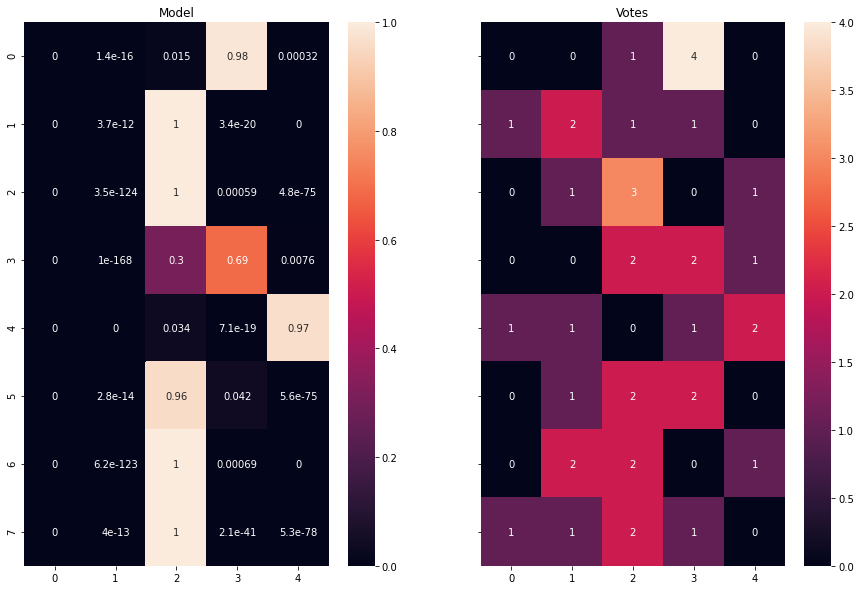

In [139]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)
num_questions = 8

seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
seaborn.heatmap(posterior[:num_questions], annot=True, ax =ax1)
ax1.set_title("Model")
ax2.set_title("Votes")
plt.show()

# Model Bt

Let us compare the estimates from B to Bt. Employing the same methods as for B:

In [169]:

model = ModelBt.create_initial_state(5, 5)
model.map(mtAnno.annotations)

print(model.theta)

[0.61328423 0.46264123 0.99999999 0.6415708  0.40183341]


In [144]:
posterior = model.infer_labels(mtAnno.annotations)

Let us analyze the heatmap for Bt:

In [145]:
votes = []
for r in mtAnno.annotations:
    v = [0] * len(mtAnno.labels)
    votes.append(v)
    for a in r:
        if a > -1:
            v[a] += 1
votes_array = np.array(votes)

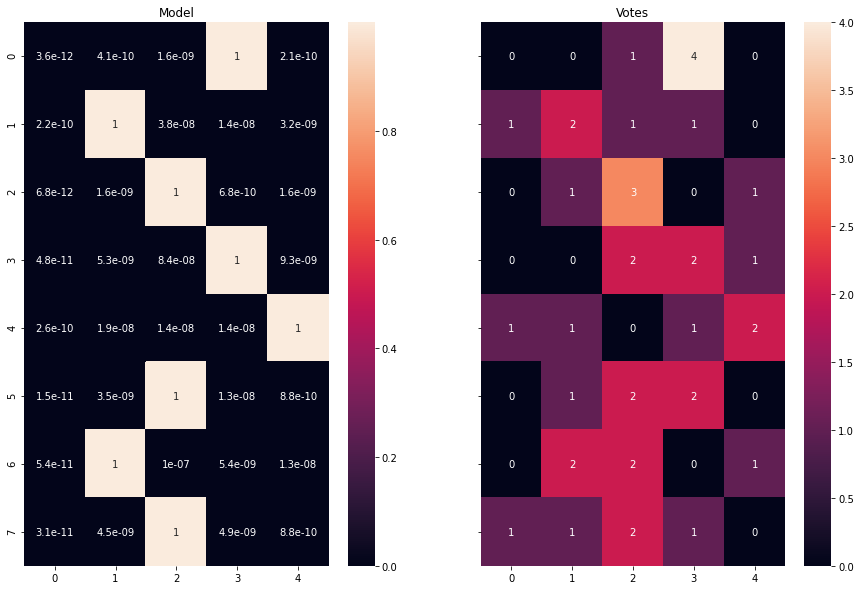

In [146]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)
num_questions = 8

seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
seaborn.heatmap(posterior[:num_questions], annot=True, ax =ax1)
ax1.set_title("Model")
ax2.set_title("Votes")
plt.show()

Let us calculate the credible interval for our theta estimates:

In [156]:
model = ModelBt.create_initial_state(5, 5)
model.map(mtAnno.annotations)
samples = model.sample_posterior_over_accuracy(mtAnno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)#.mean(axis = 1).mean(axis = 1)
y_ci = samples.std(axis=0)#.mean(axis = 1).mean(axis = 1)

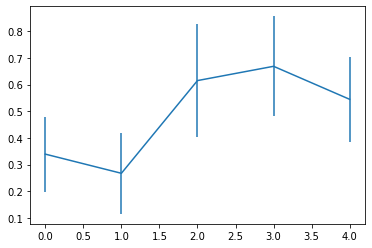

In [157]:
plt.figure()
plt.errorbar(range(5),y, yerr = y_ci)
plt.show()